In [2]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import re
import math   
from scipy import stats
import random
import pickle

In [3]:
np.random.seed(42)
random.seed(42)

In [18]:
df = pd.read_csv('./records_tests/test_record_1000_sim_1e-06_exp_100_runs_600_tree_05292022124727.csv')

In [19]:
with open('./records_tests/test_record_1000_sim_1e-06_exp_100_runs_600_tree_05292022124727.pkl', 'rb') as f:
    d = pickle.load(f)

In [20]:
d

Namespace(learning_rate=1.0, discount_factor=0.95, base_query_cost=1.0, exploration_const=1e-06, max_simulations=1000, horizon=500, arms_thetas=(0.2, 0.8), runs=100, delayed_tree_expansion=600, increase_factor=2.0, decrease_factor=0.5)

## Checking query probability

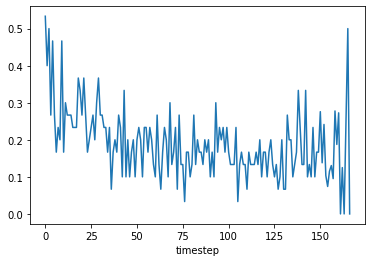

In [21]:
df.groupby(by=['timestep']).mean()['query_ind'].plot()
plt.show()

In [22]:
df.query_cost.value_counts()

1.0    3783
2.0     901
4.0      91
8.0      12
Name: query_cost, dtype: int64

## Check arms convergence

In [23]:
df.groupby('run').mean()['chosen_arm'].round(0).value_counts()

1.0    21
0.0     9
Name: chosen_arm, dtype: int64

## Avg. Reward per Timestep

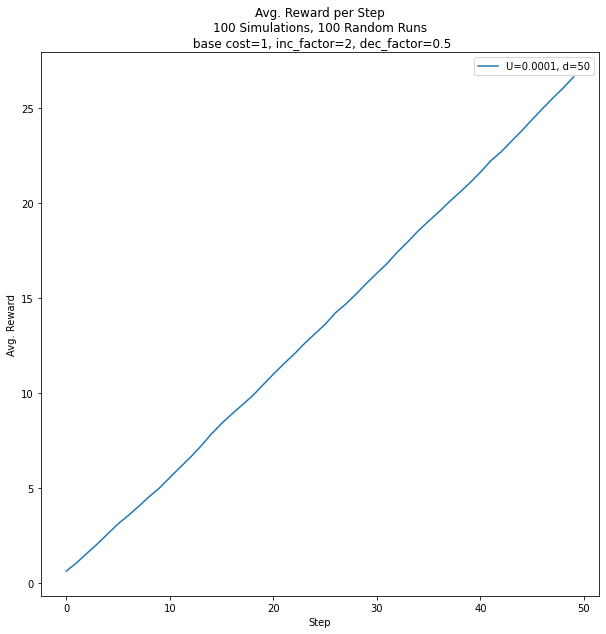

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df.groupby(['timestep']).mean()['reward'].expanding().sum().plot(
        ax=ax, title='Avg. Reward per Step\n100 Simulations, 100 Random Runs\n base cost=1, inc_factor=2, dec_factor=0.5', xlabel='Step', ylabel='Avg. Reward', label='U=0.0001, d=50')

ax.legend()
plt.show()

## Avg. Regret

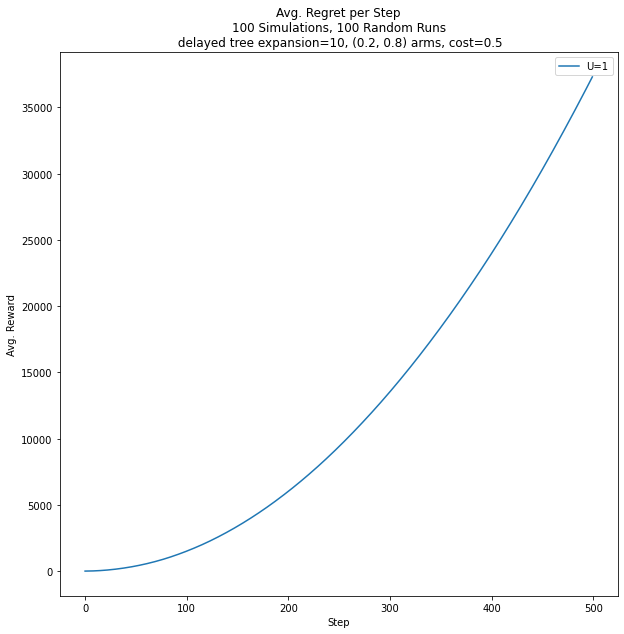

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df_100_sim.groupby(['timestep']).mean()['regret'].expanding().sum().plot(
        ax=ax, title='Avg. Regret per Step\n100 Simulations, 100 Random Runs\n delayed tree expansion=10, (0.2, 0.8) arms, cost=0.5', xlabel='Step', ylabel='Avg. Reward', label='U=1')
ax.legend()
plt.show()

## Compare with Sveta's

In [10]:
#only for KG and MCCH
def plot_cum_reg_and_arms (df_KG, df_MCCH, horizon, runs, mus, labels = ('MCCH', 'KG')):
    cregret_kg = []
    cregret_mcch = []
    cregret_kg_mean = []
    cregret_mcch_meam = []
    arms_kg = []
    arms_mcch = []
    
    for i in range(runs):
        temp_row_kg = []
        temp_row_mcch = []
        
        
        run_i_kg =  df_KG.loc[df_KG['run'] == i]
        run_i_mcch = df_MCCH.loc[df_MCCH['run'] == i]
        
        run_i_arm_count_kg = list(run_i_kg['arm'].value_counts().reindex(df_KG.arm.unique(), fill_value = 0).sort_index())
        run_i_arm_count_mcch = list(run_i_mcch['arm'].value_counts().reindex(df_MCCH.arm.unique(), fill_value = 0).sort_index())
        
        last_saved_iter_kg = run_i_kg.loc[run_i_kg['iter'] != (horizon -1)]['iter'].max()
        last_saved_iter_mcch = run_i_mcch.loc[run_i_mcch['iter'] != (horizon -1)]['iter'].max()
        
        
        run_i_cregret_kg = list(run_i_kg['regret'])
        run_i_cregret_mcch = list(run_i_mcch['regret'])
        
        
        runi_chosen_arm_kg = int(run_i_kg.loc[run_i_kg['iter']==(horizon-1)].arm)
        runi_chosen_arm_mcch = int(run_i_mcch.loc[run_i_mcch['iter']==(horizon-1)].arm)
        
        run_i_arm_count_kg[runi_chosen_arm_kg] = horizon - sum(run_i_arm_count_kg) + run_i_arm_count_kg[runi_chosen_arm_kg]
        run_i_arm_count_mcch[runi_chosen_arm_mcch] = horizon - sum(run_i_arm_count_mcch) + run_i_arm_count_mcch[runi_chosen_arm_mcch]
        
        arms_kg.append(run_i_arm_count_kg)
        arms_mcch.append(run_i_arm_count_mcch)
    
        
        complete_kg = np.linspace(run_i_cregret_kg[-2], run_i_cregret_kg[-1], (horizon - last_saved_iter_kg))
        complete_mcch = np.linspace(run_i_cregret_mcch[-2], run_i_cregret_mcch[-1], (horizon - last_saved_iter_mcch))
        
        cregret_kg_full = np.append(run_i_cregret_kg[:last_saved_iter_kg], complete_kg)
        cregret_mcch_full = np.append(run_i_cregret_mcch[:last_saved_iter_mcch], complete_mcch)
        
        cregret_kg.append(cregret_kg_full)
        cregret_mcch.append(cregret_mcch_full)

        
    
    cregret_kg_tran = np.array(cregret_kg).transpose()
    cregret_mcch_tran = np.array(cregret_mcch).transpose()
    
    
    sem_cregret_kg = []
    sem_cregret_mcch = []
    
    
    for kg_item, mcch_item in zip(cregret_kg_tran, cregret_mcch_tran):
        cregret_kg_mean.append(kg_item.mean()) 
        cregret_mcch_meam.append(mcch_item.mean())
        sem_cregret_kg.append(stats.sem(kg_item))
        sem_cregret_mcch.append(stats.sem(mcch_item))
    
    print()
    np_cregret_kg_mean = np.array(cregret_kg_mean)
    np_cregret_mcch_mean = np.array(cregret_mcch_meam)
    
    np_sem_cregret_kg = np.array(sem_cregret_kg)
    np_sem_cregret_mcch = np.array(sem_cregret_mcch)
    

    arms_avg_kg = list(np.mean(arms_kg, axis=0))
    arms_avg_mcch = list(np.mean(arms_mcch, axis=0))

    print(arms_avg_kg)
    

    print("kg:", arms_avg_kg)
    print("mcch:", arms_avg_mcch)

    
    #===================PLOTs====================
    rng = np.arange(horizon)
    
    fig = plt.figure(figsize=(12,6))
    grid = plt.GridSpec(1,2)
    cregret_plot = fig.add_subplot(grid[0,0])
    arms_hist = fig.add_subplot(grid[0,1])
    
    cregret_plot.plot(rng, cregret_mcch_meam, label =labels[0])
    cregret_plot.plot(rng, cregret_kg_mean, label = labels[1])
    
    cregret_plot.fill_between(rng, np_cregret_mcch_mean + np_sem_cregret_mcch, np_cregret_mcch_mean - np_sem_cregret_mcch, alpha=0.1)
    cregret_plot.fill_between(rng, np_cregret_kg_mean + np_sem_cregret_kg, np_cregret_kg_mean - np_sem_cregret_kg, alpha=0.1)

    cregret_plot.set_title('Cumulative Regret')
    cregret_plot.set_xlabel('time steps')
    cregret_plot.set_ylabel('average cumulative regret')
    cregret_plot.legend()   #plt.legend()

    
    arms_np = np.arange(len(arms_avg_kg))
    print(arms_np)
    width = 0.35 

    arms_hist.bar(arms_np+width/2, arms_avg_mcch, width = 0.35,  label="chosen arms")
    arms_hist.bar(arms_np-width/2, arms_avg_kg, width = 0.35, label="chosen arms")
    arms_hist.set_xticks(arms_np)
    arms_hist.set_ylabel("average number of arms")


    arms_hist.set_title('Average Chosen Actions (arms)')
    
    plt.savefig('testplot.png')

In [11]:
res = pd.read_csv("./svetas/500iter_runs_alpha01_2arms_02_08_results_2021_12_05-11_38_24.csv")
res_sum = pd.read_csv("./svetas/500iter_runs_alpha01_2arms_02_08_summary_2021_12_05-11_38_24.csv")

In [12]:
KG_res = res.loc[(res ['policy'] == 'knowledgeGradientPolicy')]
MCCH_res = res.loc[(res['policy'] == 'MCCH')]


[51.3, 448.7]
kg: [51.3, 448.7]
mcch: [2.25, 497.75]
[0 1]


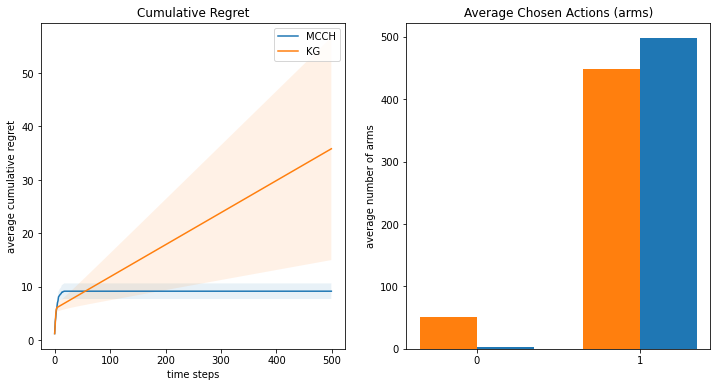

In [13]:
plot_cum_reg_and_arms(KG_res, MCCH_res, 500, 20, '[0.2, 0.8]')

In [14]:
keep_iters = MCCH_res.iter.unique().tolist()
keep_runs = MCCH_res.run.unique().tolist()
print(len(keep_iters))
print(len(keep_runs))

29
20


In [26]:
BAMCPP_res = df_100_sim.rename(columns={'chosen_arm': 'arm', 'timestep': 'iter'})
BAMCPP_res = BAMCPP_res[BAMCPP_res.run.isin(keep_runs)]
BAMCPP_res = BAMCPP_res[BAMCPP_res.iter.isin(keep_iters)]
BAMCPP_res

,run,iter,mus,base_query_cost,query_cost,horizon,regret,arm,query_ind,reward,seed
0,7,0,"(0.2, 0.8)",1,1.0,500,0.8,0,0,0,7
1,14,0,"(0.2, 0.8)",1,1.0,500,0.8,0,0,0,14
2,0,0,"(0.2, 0.8)",1,1.0,500,-0.2,1,0,1,0
4,7,1,"(0.2, 0.8)",1,1.0,500,1.6,0,0,0,7
5,14,1,"(0.2, 0.8)",1,1.0,500,1.6,1,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...
12103,13,27,"(0.2, 0.8)",1,1.0,500,8.4,1,0,0,13
12104,6,26,"(0.2, 0.8)",1,1.0,500,8.6,1,0,1,6
12108,6,27,"(0.2, 0.8)",1,1.0,500,8.4,1,0,1,6
13991,13,499,"(0.2, 0.8)",1,1.0,500,157.0,0,0,0,13



[275.3, 224.7]
kg: [275.3, 224.7]
mcch: [2.25, 497.75]
[0 1]


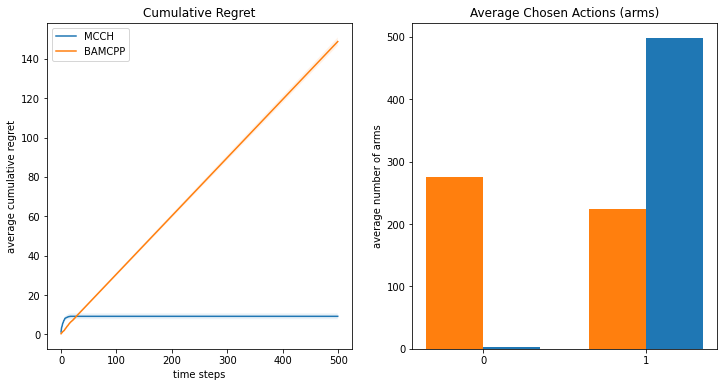

In [16]:
plot_cum_reg_and_arms(BAMCPP_res, MCCH_res, 500, 20, '[0.2, 0.8]', labels=('MCCH', 'BAMCPP'))

In [ ]:
plot_cum_reg_and_arms(BAMCPP_res, KG_res, 500, 20, '[0.2, 0.8]', labels=('KG', 'BAMCPP'))